In [157]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import statsmodels.api as sm
from scipy.stats import norm
from scipy import stats
import seaborn as sns
import numpy as np

In [158]:
# Splitting the data into n_splits=10 folds using Kfold

def split_test_train(data):
    #kf = KFold(n_splits = 10, shuffle = True, random_state = 1)
    kf = KFold(n_splits = 3, shuffle = True, random_state = 1)

    result = next(kf.split(df), None)
    df_train = df.iloc[result[0]]
    df_test = df.iloc[result[1]]
    print("train data ->", df_train )
    print("test data ->", df_test)
    return df_train, df_test

In [159]:
# DESCRIPTIVE ANALYSIS

#Input Data:
# Segment_id: ID code for the data segment. Matches the name of the associated data file.
# time_to_eruption: The target value, the time until the next eruption.

df = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/train.csv")
df.head()

#Put a testing set aside and do not look at it before you test your model. Split the data into a training and a validation set. 
#df_train, df_test = split_test_train(df)
#COMMENTING FOR NOW

,segment_id,time_to_eruption
0,1002575641,9924307
1,1001732002,20549733
2,1002624617,8004890
3,1000554676,6347792
4,1000015382,16258654


In [320]:
# Do they follow the same distribution? Use a Q-Q plot to show their relations.
#sm.qqplot(df_test["time_to_eruption"],fit=True, line="45")
#sm.qqplot(df_train["time_to_eruption"],fit=True, line="45")

In [321]:
# Show the histogram of some selected variables and describe what you conclude.

#fig = plt.hist(df_train["time_to_eruption"], bins=100)
#plt.xlabel('Time to eruption', size=15)
#plt.ylabel('Frequency', size=15)

# This distribution looks closer to Uniform

In [129]:
# Describe the data using its range, sample mean, sample standard deviation and some quantiles.
df_train.describe()

,segment_id,time_to_eruption
count,6.000000e+00,6.000000e+00
mean,1.001834e+09,1.573835e+07
std,9.895560e+05,1.533094e+07
min,1.000555e+09,5.120693e+06
25%,1.000992e+09,6.656127e+06
50%,1.002154e+09,8.752719e+06
75%,1.002601e+09,1.789338e+07
max,1.002789e+09,4.490645e+07


In [314]:
# Added new column to display days_to_eruption by converting time in centiseconds to days
df['days_to_eruption']=df['time_to_eruption']/(100*60*60*24)
df


,segment_id,time_to_eruption,days_to_eruption,class,sensor_1_mean,sensor_2_mean
0,1002575641,9924307,1.148647,B,1.660156,-0.765154
1,1001732002,20549733,2.378441,B,0.904102,-4.544324
2,1002624617,8004890,0.926492,A,3.318545,-10.278162
3,1000554676,6347792,0.734698,A,-3.828120,7.063966
4,1000015382,16258654,1.881789,B,0.382244,2.266563
5,1002789083,7581131,0.877446,A,3.518091,-1.719305
6,1001461087,10393161,1.202912,B,2.071582,1.194780
7,1000745424,5120693,0.592673,A,8.291928,-1.646423
8,1002609771,44906449,5.197506,B,-0.039533,-2.755154
9,1002275321,31353326,3.628857,B,-0.663439,0.000000


In [161]:
# To check how many data points have days_to_eruption <=1
df[df['days_to_eruption']<=1].head()

,segment_id,time_to_eruption,days_to_eruption
2,1002624617,8004890,0.926492
3,1000554676,6347792,0.734698
5,1002789083,7581131,0.877446
7,1000745424,5120693,0.592673


In [322]:
# To check how many data points have days_to_eruption >1
df[df['days_to_eruption']>1].head()


,segment_id,time_to_eruption,days_to_eruption,class,sensor_1_mean,sensor_2_mean
0,1002575641,9924307,1.148647,B,1.660156,-0.765154
1,1001732002,20549733,2.378441,B,0.904102,-4.544324
4,1000015382,16258654,1.881789,B,0.382244,2.266563
6,1001461087,10393161,1.202912,B,2.071582,1.194780
8,1002609771,44906449,5.197506,B,-0.039533,-2.755154


In [323]:
# Create a new column to identify two classes based on the days of eruption
# 'A' for days_to_eruption <=1
# 'B' for days_to_eruption >1
df['class']=df['days_to_eruption'].apply(lambda x: "A" if x <= 1 else "B" )
df.head(10)


,segment_id,time_to_eruption,days_to_eruption,class,sensor_1_mean,sensor_2_mean
0,1002575641,9924307,1.148647,B,1.660156,-0.765154
1,1001732002,20549733,2.378441,B,0.904102,-4.544324
2,1002624617,8004890,0.926492,A,3.318545,-10.278162
3,1000554676,6347792,0.734698,A,-3.828120,7.063966
4,1000015382,16258654,1.881789,B,0.382244,2.266563
5,1002789083,7581131,0.877446,A,3.518091,-1.719305
6,1001461087,10393161,1.202912,B,2.071582,1.194780
7,1000745424,5120693,0.592673,A,8.291928,-1.646423
8,1002609771,44906449,5.197506,B,-0.039533,-2.755154
9,1002275321,31353326,3.628857,B,-0.663439,0.000000


In [221]:
# Using sensor_1_mean, sensor_2_mean from segment files
index=0
for seg_id in df['segment_id']:
    df_seg_id = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/train/"+str(int(seg_id))+".csv")
    #print(seg_id, sensor_1_mean)
    df.loc[index,'sensor_1_mean'] = df_seg_id['sensor_1'].mean(axis = 0)
    df.loc[index,'sensor_2_mean'] = df_seg_id['sensor_2'].mean(axis = 0)
    index+=1

In [293]:
df=df.fillna(0)
df

,segment_id,time_to_eruption,days_to_eruption,class,sensor_1_mean,sensor_2_mean
0,1002575641,9924307,1.148647,B,1.660156,-0.765154
1,1001732002,20549733,2.378441,B,0.904102,-4.544324
2,1002624617,8004890,0.926492,A,3.318545,-10.278162
3,1000554676,6347792,0.734698,A,-3.828120,7.063966
4,1000015382,16258654,1.881789,B,0.382244,2.266563
5,1002789083,7581131,0.877446,A,3.518091,-1.719305
6,1001461087,10393161,1.202912,B,2.071582,1.194780
7,1000745424,5120693,0.592673,A,8.291928,-1.646423
8,1002609771,44906449,5.197506,B,-0.039533,-2.755154
9,1002275321,31353326,3.628857,B,-0.663439,0.000000


In [264]:
# Seperating two classes into 2 dataframes
df0 = df[df['class']=='A']
df1 = df[df['class']=='B']
df0.head(10)

,segment_id,time_to_eruption,days_to_eruption,class,sensor_1_mean,sensor_2_mean
2,1002624617,8004890,0.926492,A,3.318545,-10.278162
3,1000554676,6347792,0.734698,A,-3.828120,7.063966
5,1002789083,7581131,0.877446,A,3.518091,-1.719305
7,1000745424,5120693,0.592673,A,8.291928,-1.646423


In [265]:
df1.head(10)

,segment_id,time_to_eruption,days_to_eruption,class,sensor_1_mean,sensor_2_mean
0,1002575641,9924307,1.148647,B,1.660156,-0.765154
1,1001732002,20549733,2.378441,B,0.904102,-4.544324
4,1000015382,16258654,1.881789,B,0.382244,2.266563
6,1001461087,10393161,1.202912,B,2.071582,1.194780
8,1002609771,44906449,5.197506,B,-0.039533,-2.755154
9,1002275321,31353326,3.628857,B,-0.663439,0.000000


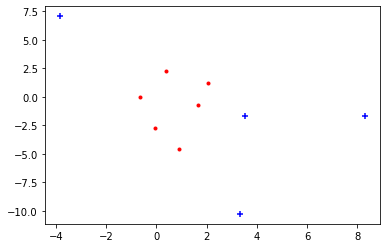

In [300]:
plt.scatter(df0['sensor_1_mean'],df0['sensor_2_mean'],color='blue',marker='+')
plt.scatter(df1['sensor_1_mean'],df1['sensor_2_mean'],color='red',marker='.')
plt.show()

In [294]:
from sklearn.model_selection import train_test_split

X=df.drop(['segment_id','time_to_eruption','days_to_eruption','class'], axis='columns')
X.head()

,sensor_1_mean,sensor_2_mean
0,1.660156,-0.765154
1,0.904102,-4.544324
2,3.318545,-10.278162
3,-3.828120,7.063966
4,0.382244,2.266563


In [295]:
y=df['class']
y

0    B
1    B
2    A
3    A
4    B
5    A
6    B
7    A
8    B
9    B
Name: class, dtype: object

In [315]:
X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.2)
print(len(X_train),len(X_test))

8 2


In [316]:
from sklearn.svm import SVC
model=SVC(C=100)

In [317]:
model.fit(X_train,y_train)

SVC(C=100)

In [318]:
model.score(X_test, y_test)

1.0

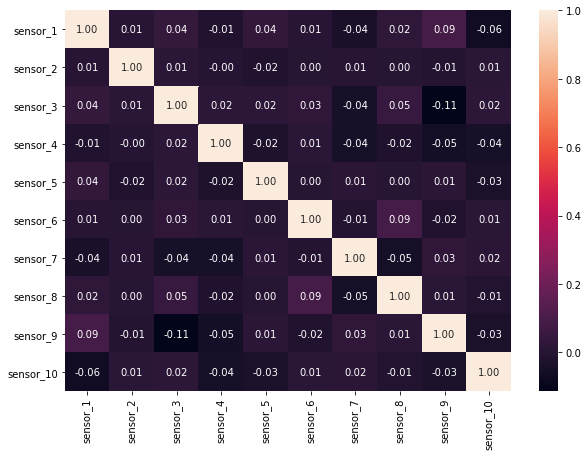

In [312]:
# Show the dependence of some selected variables and describe what you conclude.
df_1 = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/train/1002575641.csv")

fig = plt.figure(figsize=(10,7))
sns.heatmap(df_1.corr(),annot=True,fmt=".2f");

# Observation: There is no correlation between the sensors

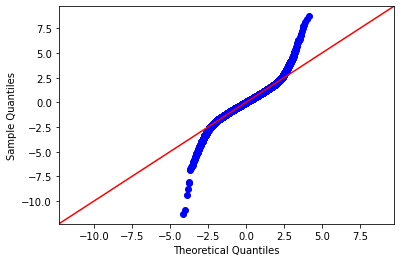

In [9]:
# Mean sensor data for each row

sensor_mean = df_1.mean(axis = 1) 
sm.qqplot(sensor_mean,fit=True, line="45")
plt.show()

# As the QQ plot depicts straight line this appears to be normally distributed data

In [10]:
# Explain how your analysis relates to the objective of your project, i.e. why are these selected variables important? 
print(sensor_mean)

0         61.9
1        123.9
2        160.1
3        144.6
4        119.9
         ...  
59996    192.1
59997    176.1
59998    129.6
59999     91.8
60000     57.0
Length: 60001, dtype: float64


Mean  0.576494465832972
Median  0.6
Std dev  89.22392572006876


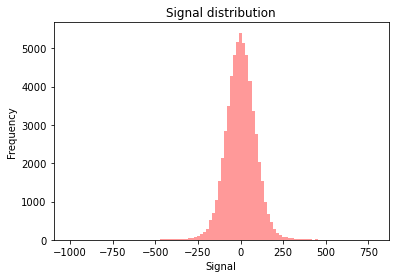

In [11]:
# Probability distribution: 
# Use probability distributions to describe some selected variables.
# What are the parameters in the distribution? Estimate these parameters.

ax=sns.distplot(sensor_mean, kde = False, color ='red', bins = 100)
ax.set_xlabel("Signal")
ax.set_ylabel("Frequency")
ax.set_title("Signal distribution");

print("Mean ",sensor_mean.mean())
print("Median ",sensor_mean.median())
print("Std dev ", sensor_mean.std())

# We can see that the Sensor_data looks very gaussian and balanced
# The parameters are mean(mu) and std dev(sigma)
# Below plot shows the signal at the median and mean around -6 and 0. 


In [ ]:
Trends between max of each sensor data and time_to_eruption.
Trends between minimum of each sensor data and time_to_eruption.
Trends between mean of each sensor data and time_to_eruption.
Trends between variance of each sensor data and time_to_eruption.


Each_sensor max:
 sensor_1      1893.0
sensor_2     10216.0
sensor_3      1928.0
sensor_4      1898.0
sensor_5      1475.0
sensor_6      1060.0
sensor_7      1840.0
sensor_8      2642.0
sensor_9      3040.0
sensor_10     4768.0
dtype: float64

Each sensor min:
 sensor_1     -2176.0
sensor_2    -11197.0
sensor_3     -1826.0
sensor_4     -1968.0
sensor_5     -1536.0
sensor_6     -1002.0
sensor_7     -1346.0
sensor_8     -2158.0
sensor_9     -2448.0
sensor_10    -4497.0
dtype: float64
time_to_eruption Series([], Name: time_to_eruption, dtype: int64)


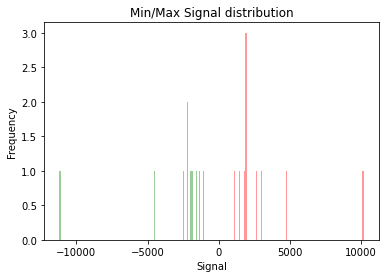

,Max_signal,Min_signal
sensor_1,1893.0,-2176.0
sensor_2,10216.0,-11197.0
sensor_3,1928.0,-1826.0
sensor_4,1898.0,-1968.0
sensor_5,1475.0,-1536.0
sensor_6,1060.0,-1002.0
sensor_7,1840.0,-1346.0
sensor_8,2642.0,-2158.0
sensor_9,3040.0,-2448.0
sensor_10,4768.0,-4497.0


In [313]:
# Mean sensor data for each sensor column
df_1 = pd.read_csv("../../predict-volcanic-eruptions-ingv-oe/train/1002575641.csv")
each_sensor_max = df_1.max(axis = 0) 

each_sensor_min = df_1.min(axis = 0) 
print("Each_sensor max:\n",each_sensor_max)
print("\nEach sensor min:\n",each_sensor_min)

#df_train.info()
time_to_eruption = df_train.loc[df_train['segment_id']== 1000015382, 'time_to_eruption']
#time_to_eruption = df_train.loc[df_train['segment_id']== 1000745424, 'time_to_eruption']
print("time_to_eruption",time_to_eruption)

ax=sns.distplot(each_sensor_max, kde = False, color ='red', bins = 100)
ax=sns.distplot(each_sensor_min, kde = False, color ='green', bins = 100)
ax.set_xlabel("Signal")
ax.set_ylabel("Frequency")
ax.set_title("Min/Max Signal distribution");
plt.show()

frame = { 'Max_signal': each_sensor_max, 'Min_signal': each_sensor_min } 
df_new=pd.DataFrame(frame)
df_new.head(10)


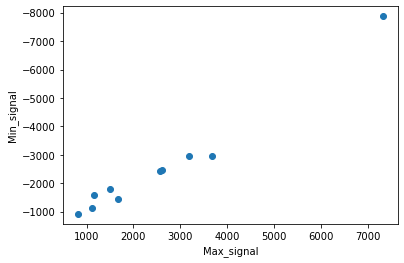

In [13]:

plt.scatter(df_new['Max_signal'], df_new['Min_signal'])
plt.xlabel('Max_signal')
plt.ylabel('Min_signal')
plt.gca().invert_yaxis()
plt.show()



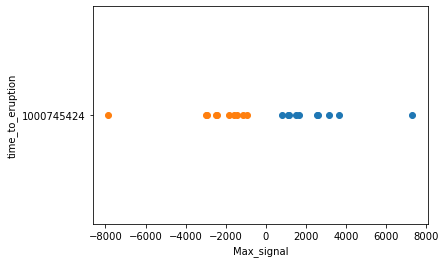

In [14]:

df_new['time_to_eruption'] = "1000745424"
df_new.head()

plt.scatter(df_new['Max_signal'], df_new['time_to_eruption'])
plt.scatter(df_new['Min_signal'], df_new['time_to_eruption'])
plt.xlabel('Max_signal')
plt.ylabel('time_to_eruption')
plt.show()